In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M11\2.11 result\grouped_procedures_6_months.csv"
df_grouped_all = pd.read_csv(full_dataset, encoding="Windows-1252")

Basic_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M11\2.11 result\grouped_procedures_non_basic_3_months.csv"
df_grouped = pd.read_csv(Basic_dataset, encoding="Windows-1252")

## Consider to use other methods for correlation detection
1. Co-Occurrence Analysis (in single code case)   Co-Occurrence Matrix 
Co-Occurrence Analysis (in Multiple code case) Apriori  

2. Hierarchical Clustering – Grouping Similar Treatments (Unsupervised Machine Learning)  
Uses distance metrics to create a dendrogram (tree-like) showing which treatments are most related.
Example: cluster {X-rays, Fillings, Cleanings} in one group and {Implants, Root Canals, Crowns} in another, the alogrithm indicating common patient pathways.

3. Graph-Based Analysis – Network of Treatment Relationships (Network Analysis)
Creates a network where each node represents a procedure and edges represent their co-occurrence.  

In [13]:
import itertools
import seaborn as sns
import ast

df_grouped['procedure_codes'] = df_grouped['procedure_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
all_procedure_codes = list(set(itertools.chain.from_iterable(df_grouped['procedure_codes'])))

# Initialize
co_occurrence_matrix = pd.DataFrame(0, index=all_procedure_codes, columns=all_procedure_codes, dtype=int)

# Populate co-occurrence counts
for procedures in df_grouped['procedure_codes']:
    for proc1, proc2 in itertools.combinations(procedures, 2):
        co_occurrence_matrix.loc[proc1, proc2] += 1
        co_occurrence_matrix.loc[proc2, proc1] += 1


In [14]:
# co_occurrence_matrix.to_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M12\co_occurrence_matrix_non_basic.csv")

In [15]:
# Extract top 10 most frequently co-occurring procedure pairs
co_occurrence_flat = co_occurrence_matrix.where(np.triu(np.ones(co_occurrence_matrix.shape), k=1).astype(bool)) # Only the upper triangle is enough
top_10_pairs = co_occurrence_flat.stack().sort_values(ascending=False).head(10)
top_10_pairs_df = top_10_pairs.reset_index()
top_10_pairs_df.columns = ["Procedure 1", "Procedure 2", "Co-Occurrence Count"]
print("Top 10 Most Frequently Co-Occurring Procedure Pairs:")
print(top_10_pairs_df)

Top 10 Most Frequently Co-Occurring Procedure Pairs:
  Procedure 1 Procedure 2  Co-Occurrence Count
0       27211       99111               2139.0
1       49510       49421               1311.0
2       23321       23322               1184.0
3       23323       23322                825.0
4       67211       62501                791.0
5       23312       23322                772.0
6       23311       23321                687.0
7       62501       99111                641.0
8       67211       99111                619.0
9       49421       49512                599.0


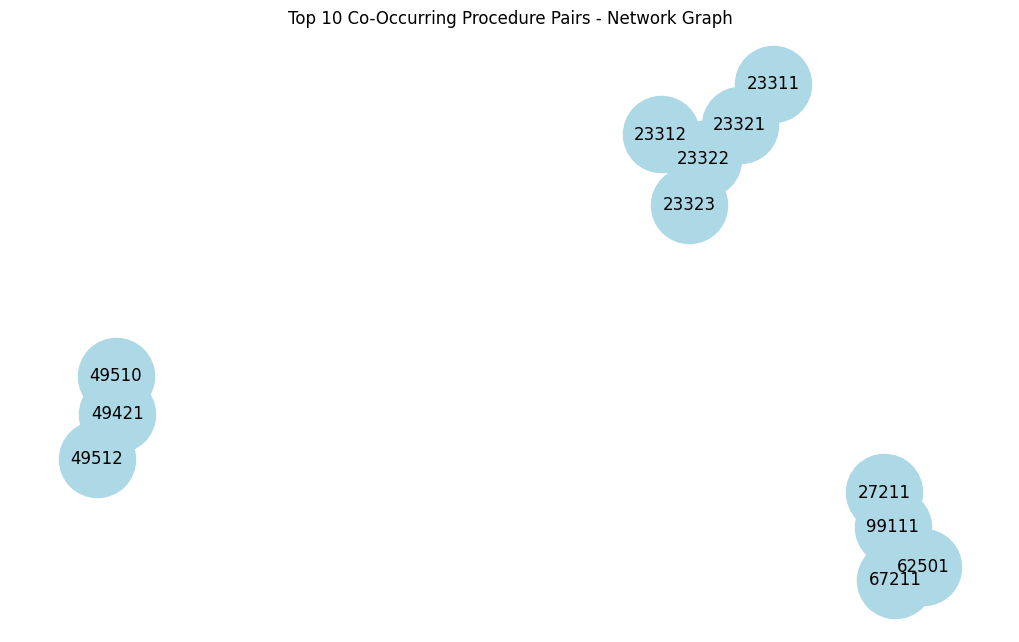

In [16]:
import networkx as nx
# NetworkX is a Python library for visualizing and analyzing relationships between connected elements.
G = nx.Graph()

# Add edges based on the top 10 pairs
for _, row in top_10_pairs_df.iterrows():
    G.add_edge(row["Procedure 1"], row["Procedure 2"], weight=row["Co-Occurrence Count"]) # adds an edge between the two procedure codes, assigning a weight based on how frequently they co-occur.

# Draw the network graph
# Idea of spring layout: Nodes repel each other, like charged particles. Edges act like springs, pulling related nodes together.
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42) # Highly co-occurring treatments are positioned closer

edges = G.edges(data=True)
weights = [edata["weight"] for _, _, edata in edges]
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color=weights, width=2.0, edge_cmap=plt.cm.Blues)
plt.title("Top 10 Co-Occurring Procedure Pairs - Network Graph")
plt.show()

It helps in understanding how different dental treatments are related based on their co-occurrence in patient records.  
23311, 23321, 23322, 23323, and 23312 are closely connected, meaning they are frequently performed together.  
23311	Restorations, Tooth Coloured, Permanent Posteriors – Bonded Permanent Bicuspids - One surface	220.00  
23312	Restorations, Tooth Coloured, Permanent Posteriors – Bonded Permanent Bicuspids - Two surfaces	275.00  
23321	Restorations, Tooth Coloured, Permanent Posteriors - Bonded Permanent Molars - One surface	240.00  
23322	Restorations, Tooth Coloured, Permanent Posteriors - Bonded Permanent Molars - Two surfaces	300.00  
23323	Restorations, Tooth Coloured, Permanent Posteriors - Bonded Permanent Molars - Three surfaces	360.00  

27211, 99111, 62501, 67211 are highly co-occurring.  
27211	Crown, Porcelain/Ceramic/Polymer Glass Fused to Metal Base + L	1,073.00  
62501	Pontics, Porcelain/Ceramic/Polymer Glass Fused to Metal + L	538.00    				
99111	+L Commercial Laboratory Procedures I.C. 

49512, 49421, 49510 are also highly co-occurring. 
Cannot find the corresponding description 


In [17]:
# Try Hierarchical Clustering
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch

# Convert co-occurrence counts into a distance metric
distance_matrix = pdist(co_occurrence_matrix, metric="euclidean")
distance_matrix

array([321.47939281,   7.81024968,  17.80449381, ...,  88.04544281,
        18.        ,  92.36882591])

In [18]:
# Compute linkage matrix using Ward's method; Ward’s method minimizes variance within clusters.
linkage_matrix = sch.linkage(distance_matrix, method="ward")
print(linkage_matrix[:5])

[[ 28.  33.   0.   2.]
 [ 60. 542.   0.   3.]
 [ 68. 543.   0.   4.]
 [ 73. 544.   0.   5.]
 [108. 545.   0.   6.]]


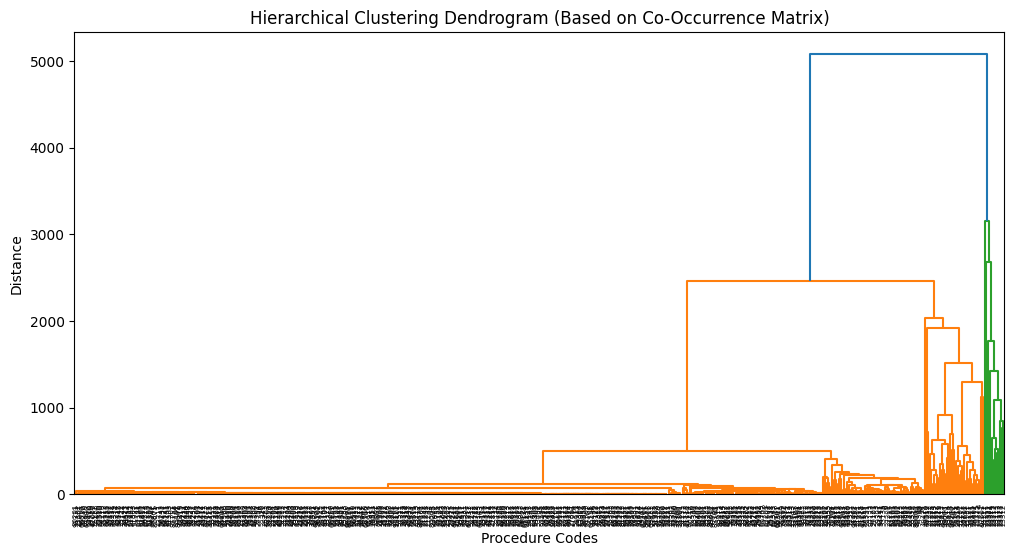

In [19]:
# Plot the dendrogram
# Displays how procedures group together in a hierarchical tree.
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix, labels=co_occurrence_matrix.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Based on Co-Occurrence Matrix)")
plt.xlabel("Procedure Codes")
plt.ylabel("Distance")
plt.show()

In [20]:
from scipy.cluster.hierarchy import fcluster

# Set the number of clusters (or distance threshold)
num_clusters = 10  # Adjust
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Create a DataFrame to store procedure cluster assignments
procedure_clusters = pd.DataFrame({'Procedure': co_occurrence_matrix.index, 'Cluster': clusters})
procedure_clusters

,Procedure,Cluster
0,72231,1
1,33111,4
2,42201,1
3,32311,1
4,92312,1
...,...,...
537,23512,1
538,97119,1
539,43611,1
540,94303,1


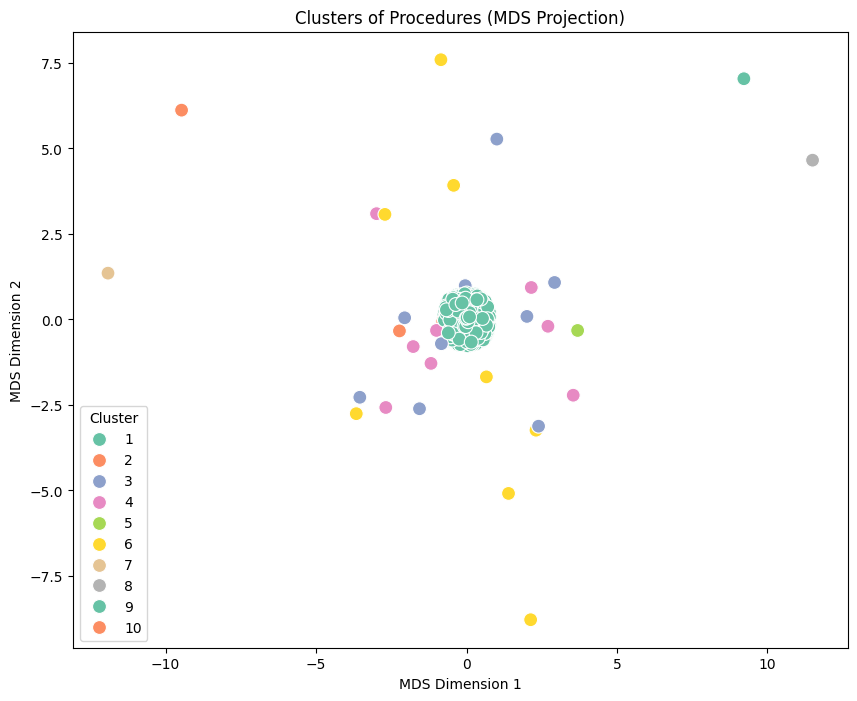

In [21]:
from sklearn.manifold import MDS

distance_matrix = 1 - co_occurrence_matrix  # Convert similarity to distance
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)
coords_df = pd.DataFrame(coords, columns=["X", "Y"], index=co_occurrence_matrix.index)
coords_df["Cluster"] = clusters  # from step 1

plt.figure(figsize=(10, 8))

# Scatter plot of procedures, colored by cluster
sns.scatterplot(
    data=coords_df,
    x="X", y="Y",
    hue="Cluster",
    palette="Set2",
    s=100
)

# # Optionally label each point with the procedure code
# for i, procedure_code in enumerate(coords_df.index):
#     plt.annotate(procedure_code, (coords_df["X"][i], coords_df["Y"][i]), fontsize=8)

plt.title("Clusters of Procedures (MDS Projection)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()